In [1]:
import h5py
import librosa
import mir_eval
import numpy as np
import os
import pandas as pd
import peakutils
import scipy.signal
import soundfile as sf
import sys
sys.path.append('../src')
import localmodule

In [ ]:

# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
bin_freqs = np.linspace(1000.0, 10000.0, 31)
bin_bandwidth = np.diff(bin_freqs)[0]

threshold_ids =\
      [[103, 102,  79, 115,   0,  91,   0, 106,   0, 135],
       [205,   0, 207,   0, 189, 170, 206, 193, 191, 184],
       [143,   0, 137, 150,   0, 158,   0, 145, 154, 118],
       [130, 158,   0, 136, 162, 133, 174, 134, 158, 140],
       [134, 131, 203, 126, 140, 131, 123, 121, 125, 139],
       [159, 186, 130, 133, 140, 161, 170, 141, 166, 168]]
threshold_ids = np.array(threshold_ids)

trials =\
      [[4, 8, 9, 6, 3, 0, 2, 1, 5, 7],
       [1, 3, 0, 9, 2, 6, 4, 8, 5, 7],
       [1, 4, 6, 8, 0, 9, 7, 5, 3, 2],
       [2, 9, 1, 5, 6, 3, 4, 8, 7, 0],
       [2, 8, 1, 0, 4, 9, 5, 7, 3, 6],
       [4, 9, 8, 6, 1, 2, 5, 3, 7, 0]]
trials = np.array(trials)

thresholds = 1.0 - np.concatenate((
    np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
))
n_thresholds = len(thresholds)

tolerance = 0.5 # in seconds

n_hours = 11
bin_hop = 30 # in minutes
n_bins = int(np.round(n_hours * (60/bin_hop)))
bins = (3600 * np.linspace(0, n_hours, 1 + n_bins)).astype('int')


# Define directory for annotations.
annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)


unit_mid_freqs = []
unit_night_durations = []
unit_recalls = []



# Loop over units.
for test_unit_id in range(6):

    # Define directory for model.
    test_unit_str = units[test_unit_id]
    aug_str = "all"
    model_name = "icassp-convnet"
    model_dir = os.path.join(models_dir, model_name)


    # Load annotation.
    annotation_path = os.path.join(annotations_dir,
        test_unit_str + ".txt")
    annotation = pd.read_csv(annotation_path, '\t')
    begin_times = np.array(annotation["Begin Time (s)"])
    end_times = np.array(annotation["End Time (s)"])
    relevant = 0.5 * (begin_times + end_times)
    relevant = np.sort(relevant)
    high_freqs = np.array(annotation["High Freq (Hz)"])
    low_freqs = np.array(annotation["Low Freq (Hz)"])
    mid_freqs = 0.5 * (high_freqs + low_freqs)
    n_relevant = len(relevant)
    unit_mid_freqs.append(mid_freqs)
    
    
    # Compute histogram of flight call frequencies.
    hist_POS, _ = np.histogram(mid_freqs, bins=bin_freqs)


    # Store night duration.
    night_duration = relevant[-1] / 3600
    unit_night_durations.append(night_duration)
    
    
    # Initialize.
    trial_recalls = []

    # Loop over units.
    for trial_id_id in [5, 7, 8, 9]:
        print(test_unit_str, trial_id_id)

        # Pick trial.
        trial_id = trials[test_unit_id, trial_id_id]


        # Pick threshold.
        threshold_id = threshold_ids[test_unit_id, trial_id]


        # Load prediction.
        test_unit_str = units[test_unit_id]
        unit_dir = os.path.join(model_dir, test_unit_str)
        trial_str = "trial-" + str(trial_id)
        trial_dir = os.path.join(unit_dir, trial_str)
        prediction_name = "_".join([
            dataset_name,
            model_name,
            "test-" + test_unit_str,
            trial_str,
            "predict-" + test_unit_str,
            "full-predictions.csv"])
        prediction_path = os.path.join(trial_dir, prediction_name)
        prediction_df = pd.read_csv(prediction_path)
        odf = np.array(prediction_df["Predicted probability"])
        timestamps = np.array(prediction_df["Timestamp"])


        # Select peaks.
        threshold = thresholds[threshold_id]
        peak_locations = peakutils.indexes(odf, thres=threshold, min_dist=3)
        selected = timestamps[peak_locations]

        # Match events for all calls.
        selected_relevant = mir_eval.util.match_events(relevant, selected, tolerance)
        tp_relevant_ids = list(zip(*selected_relevant))[0]

        # Retrieve frequencies of selected calls.
        tp_mid_freqs = [mid_freqs[i] for i in tp_relevant_ids]
        
        # Compute histogram of true positive frequencies.
        hist_TP, _ = np.histogram(tp_mid_freqs, bins=bin_freqs)
        
        # Compute histogram of recalls.
        hist_R = hist_TP / (np.finfo(float).eps + hist_POS)
        
        trial_recalls.append(hist_R)
        
        print(trial_recalls)
        
        
    unit_recalls.append(trial_recalls)
        

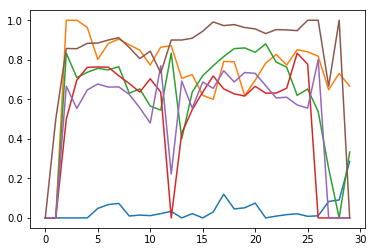

In [180]:
recall_matrix = np.stack(unit_recalls)

plt.plot(np.squeeze(recall_matrix).T)

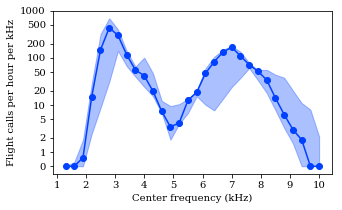

In [144]:
from matplotlib import pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots(1, 1, sharex=True, figsize=(5, 3))

abundances_y = []

for unit_test_id in range(n_units):
    abundance_y, _ = np.histogram(
        unit_mid_freqs[unit_test_id], bins=bin_freqs)
    abundances_y.append(
        abundance_y * 1000 / (bin_bandwidth * unit_night_durations[unit_test_id]))

abundances_y = np.stack(abundances_y).T

ax1.fill_between(
    bin_freqs[1:] / 1000,
    np.log10(np.maximum(np.sort(abundances_y, axis=1)[:, 1], 0.5)),
    np.log10(np.maximum(np.sort(abundances_y, axis=1)[:, 4], 0.5)),
    color = "#0040FF",
    alpha = 0.33)

ax1.plot(
    bin_freqs[1:] / 1000,
    np.log10(np.maximum(np.median(abundances_y, axis=1), 0.5)),
    "-o",
    color = "#0040FF",
    linewidth = 2.0)

xticks = range(1, 11)
ax1.set_xticks(xticks)
ax1.set_xticklabels([str(xtick) for xtick in xticks], family="serif");
ax1.set_xlabel("Center frequency (kHz)", family="serif")

yticks = [0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
ax1.set_yticks(np.log10(yticks))
ax1.set_yticklabels(["0"] + [str(ytick) for ytick in yticks[1:]], family="serif");
ax1.set_ylabel("Flight calls per hour per kHz", family="serif")

plt.savefig("icassp_fig4b.png", dpi=900)